# Reading raster bands

In [2]:
# Importing libraries
%matplotlib inline
import rasterio as rio
import matplotlib.pyplot as plt
from rasterio import plot
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

In [2]:
# open raster bands
path_B4 = 'D:/desktop/LC08_L1TP_013032_20190830_20190916_01_T1/LC08_L1TP_013032_20190830_20190916_01_T1_B4.TIF'
path_B5 = 'D:/desktop/LC08_L1TP_013032_20190830_20190916_01_T1/LC08_L1TP_013032_20190830_20190916_01_T1_B5.TIF'

B4_red = rio.open(path_B4)
B5_nir = rio.open(path_B5)

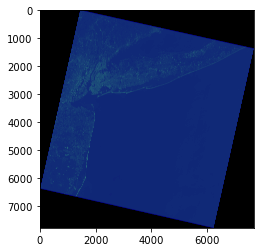

In [3]:
# To visualize band 4 (red band)
plt.imshow(B4_red.read(1), cmap='gist_earth')
plt.show()

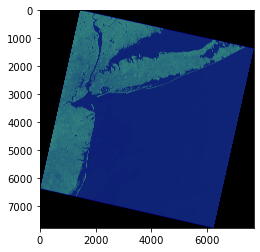

In [4]:
# To visualize band 5 (nir band)
plt.imshow(B5_nir.read(1), cmap='gist_earth')
plt.show()

# Task for calculate NDVI

In [ ]:
red = B4_red.read()
nir = B5_nir.read()
display(red)
display(nir)

In [ ]:
# Convert values to floats
red = red.astype(float)
nir = nir.astype(float)

In [10]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [59]:
def ndvi_cal(red, nir):
    red = red
    nir = nir
    ndvi = (nir - red)/(nir + red)
    return ndvi

NDVI = ndvi_cal(red, nir)

In [75]:
NDVI.shape

(1, 7781, 7651)

In [77]:
# to reshape 2D in order to plot it
NDVI_2D = np.reshape(NDVI, (NDVI.shape[0]*NDVI.shape[1], NDVI.shape[2]))
NDVI_2D.shape

(7781, 7651)

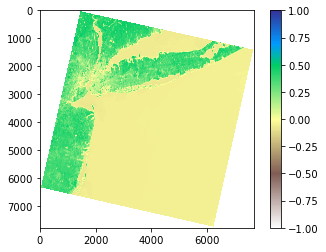

In [79]:
plt.imshow(NDVI_2D, cmap='terrain_r')
plt.colorbar()     # Add colorbar to show the index
plt.show()

# Task for creating polygon

In [12]:
# Reading metadat 
MetaData = B4_red.meta
MetaData

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 7651,
 'height': 7781,
 'count': 1,
 'crs': CRS.from_epsg(32618),
 'transform': Affine(30.0, 0.0, 528585.0,
        0.0, -30.0, 4582215.0)}

In [14]:
# Clip a shapefile from band4
lat_list = [551138.692, 575634.347, 565031.750, 540170.489]  # x
long_list = [4461066.234, 4441323.468, 4402569.148, 4412074.924]   # y

polygon_geom = Polygon(zip(lat_list, long_list))

polygon = gpd.GeoDataFrame(index=[0], geometry=[polygon_geom])
print(polygon.geometry)

polygon.to_file(filename='polygon.geojson', driver='GeoJSON')
polygon.to_file(filename='polygon.shp', driver='ESRI Shapefile')

0    POLYGON ((551138.692 4461066.234, 575634.347 4...
Name: geometry, dtype: geometry


In [15]:
path_pol = 'D:/desktop/LC08_L1TP_013032_20190830_20190916_01_T1/shapefile/polygon.shp'
data = gpd.read_file(path_pol)

# Task for mask 

In [19]:
import fiona

with fiona.open('D:/desktop/LC08_L1TP_013032_20190830_20190916_01_T1/shapefile/polygon.geojson', 'r') as vectorfile:
    shapes = [feature['geometry'] for feature in vectorfile]

In [20]:
# Clip raster with polygon
from rasterio.mask import mask
new_data = rio.open(path_B4, 'r')
img_out, transform_out = mask(dataset=new_data, shapes=shapes, crop=True)
meta_out = new_data.meta.copy()
new_data.close()

In [21]:
print(meta_out)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7651, 'height': 7781, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(30.0, 0.0, 528585.0,
       0.0, -30.0, 4582215.0)}


In [22]:
meta_out.update({'driver':'GTiff',
                'height':img_out.shape[1],
                'width':img_out.shape[2],
                'transform':transform_out})

with rio.open('D:/desktop/LC08_L1TP_013032_20190830_20190916_01_T1/shapefile/b4_clipped.tif', 'w', **meta_out) as dest:
    dest.write(img_out)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1183, 'height': 1951, 'count': 1, 'crs': CRS.from_dict(init='epsg:32618'), 'transform': Affine(30.0, 0.0, 540165.0,
       0.0, -30.0, 4461075.0), 'tiled': False, 'interleave': 'band'}


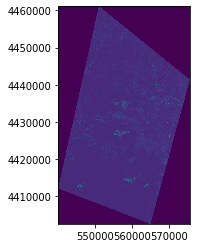

In [7]:
with rio.open('D:/desktop/LC08_L1TP_013032_20190830_20190916_01_T1/shapefile/b4_clipped.tif', 'r') as data_final:
    print(data_final.profile)
    plot.show(data_final)